In [1]:
%matplotlib inline
import collections
import pandas
import numpy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Basic Feature Preprocessing

In [3]:
data = pandas.read_csv('./diplomacy_cv.csv')
corpus = [row['text'] for (index,row) in data.iterrows()]

vectoriser = CountVectorizer()
vectors = vectoriser.fit_transform(corpus)
X = pandas.DataFrame(vectors.toarray(), columns=vectoriser.vocabulary_).values.tolist()
y = numpy.array([int(row['intent']) for (index,row) in data.iterrows()])

In [4]:
numTrain = int(len(corpus)*0.8)   # number of training instances
numTest = len(corpus) - numTrain

X_train = X[:-numTest]
X_test = X[-numTest:]
y_train = y[:-numTest]
y_test = y[-numTest:]
print(len(X_train), len(X_test))

1276 320


In [5]:
# Preprocessing
X_train_b = X_train
y_train_b = y_train
X_test_b = X_test
y_test_b = y_test

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Fit regression model to the training set
# regr.fit(X_train, y_train)

#### 3 Logistic Regression

Regular Logistic Regression

In [19]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0.0)

def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

def compute_loss_and_grad(X, y, theta, lambda_, regularizer):
    N = X.shape[0]
    z = X @ theta
    h = sigmoid(z)

    # Logistic loss (cross-entropy)
    loss = -np.mean(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))

    # Add regularization to loss (bias 不正則化)
    if regularizer == 'ridge':
        loss += (lambda_ / 2) * np.sum(theta[1:] ** 2)
    elif regularizer == 'lasso':
        loss += lambda_ * np.sum(np.abs(theta[1:]))

    # Gradient
    grad = (1/N) * X.T @ (h - y)

    # Add regularization to gradient (bias 不正則化)
    if regularizer == 'ridge':
        grad[1:] += lambda_ * theta[1:]

    return loss, grad

def train_logistic_regression(X_train, y_train, X_test, y_test, lr, epochs, lambda_=0, regularizer='none'):
    N, d = X_train.shape
    theta = np.random.randn(d) * 0.01
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        loss_train, grad = compute_loss_and_grad(X_train, y_train, theta, lambda_, regularizer)

        if regularizer == 'lasso':
            # 使用 proximal gradient（L1）
            theta[1:] = soft_threshold(theta[1:] - lr * grad[1:], lambda_ * lr)
            theta[0] -= lr * grad[0]  # bias 照常更新
        else:
            # 一般更新（none / ridge）
            theta -= lr * grad

        train_losses.append(loss_train)

        if epoch % 200 == 0:
            loss_test, _ = compute_loss_and_grad(X_test, y_test, theta, lambda_, regularizer)
            test_losses.append(loss_test)
            print(f"Epoch {epoch}, Train Loss: {loss_train:.5f} Test Loss: {loss_test:.5f}")

    print(f"\nFinal Result:")
    print(f"Total Epoch {epoch+1}, Train Loss: {loss_train:.5f} Test Loss: {loss_test:.5f}")
    return theta, train_losses, test_losses

def predict(X, theta, threshold=0.5):
    probs = sigmoid(X @ theta)
    return (probs >= threshold).astype(int)

In [8]:
X_train = add_intercept(np.array(X_train))
y_train = np.array(y_train).astype(np.float64)
X_test = add_intercept(np.array(X_test))
y_test = np.array(y_test).astype(np.float64)

In [28]:
########################################
########## Regular Fitting ##########
########################################
theta_regular, losses_regular, test_losses_regular = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.05, epochs=2000, lambda_=0, regularizer='none'
)
y_pred_train_regular = predict(X_train, theta_regular)
y_pred_test_regular = predict(X_test, theta_regular)

bias_regular = theta_regular[0]
weight_regular = theta_regular[1:]
weight_sum_regular = numpy.absolute(weight_regular).sum() + numpy.absolute(bias_regular)

Epoch 0, Train Loss: 0.69176 Test Loss: 0.69172
Epoch 200, Train Loss: 0.62817 Test Loss: 0.67157
Epoch 400, Train Loss: 0.60207 Test Loss: 0.67215
Epoch 600, Train Loss: 0.58270 Test Loss: 0.67343
Epoch 800, Train Loss: 0.56689 Test Loss: 0.67490
Epoch 1000, Train Loss: 0.55340 Test Loss: 0.67655
Epoch 1200, Train Loss: 0.54157 Test Loss: 0.67835
Epoch 1400, Train Loss: 0.53099 Test Loss: 0.68030
Epoch 1600, Train Loss: 0.52140 Test Loss: 0.68235
Epoch 1800, Train Loss: 0.51259 Test Loss: 0.68449

Final Result:
Total Epoch 2000, Train Loss: 0.50449 Test Loss: 0.68449


Ridge Logistic Regression

In [ ]:
#### Implement the Ridge Logistic Regression model, i.e., with Ridge regularization.     ####

In [22]:
########################################
########## Ridge Fitting ############
########################################
theta_ridge, losses_ridge, test_losses_ridge = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.001, epochs=6000, lambda_=0.04, regularizer='ridge'
)
y_pred_train_ridge = predict(X_train, theta_ridge)
y_pred_test_ridge = predict(X_test, theta_ridge)
bias_ridge = theta_ridge[0]
weight_ridge = theta_ridge[1:]
weight_sum_ridge = numpy.absolute(weight_ridge).sum() + numpy.absolute(bias_ridge)

Epoch 0, Train Loss: 0.69922 Test Loss: 0.70145
Epoch 200, Train Loss: 0.68916 Test Loss: 0.69325
Epoch 400, Train Loss: 0.68447 Test Loss: 0.68965
Epoch 600, Train Loss: 0.68164 Test Loss: 0.68774
Epoch 800, Train Loss: 0.67952 Test Loss: 0.68652
Epoch 1000, Train Loss: 0.67771 Test Loss: 0.68561
Epoch 1200, Train Loss: 0.67606 Test Loss: 0.68487
Epoch 1400, Train Loss: 0.67451 Test Loss: 0.68424
Epoch 1600, Train Loss: 0.67305 Test Loss: 0.68369
Epoch 1800, Train Loss: 0.67165 Test Loss: 0.68319
Epoch 2000, Train Loss: 0.67032 Test Loss: 0.68274
Epoch 2200, Train Loss: 0.66904 Test Loss: 0.68234
Epoch 2400, Train Loss: 0.66782 Test Loss: 0.68197
Epoch 2600, Train Loss: 0.66665 Test Loss: 0.68163
Epoch 2800, Train Loss: 0.66553 Test Loss: 0.68132
Epoch 3000, Train Loss: 0.66445 Test Loss: 0.68104
Epoch 3200, Train Loss: 0.66341 Test Loss: 0.68079
Epoch 3400, Train Loss: 0.66242 Test Loss: 0.68056
Epoch 3600, Train Loss: 0.66146 Test Loss: 0.68035
Epoch 3800, Train Loss: 0.66053 Test L

Lasso Logistic Regression

In [ ]:
#### Implement the Lasso Logistic Regression model, i.e., with Lasso regularization.     ####

In [37]:
########################################
########## Lasso Fitting ############
########################################
theta_lasso, losses_lasso, test_losses_lasso = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.0018, epochs=4000, lambda_=0.01, regularizer='lasso'
)
y_pred_train_lasso = predict(X_train, theta_lasso)
y_pred_test_lasso = predict(X_test, theta_lasso)
bias_lasso = theta_lasso[0]
weight_lasso = theta_lasso[1:]
weight_sum_lasso = numpy.absolute(weight_lasso).sum() + numpy.absolute(bias_lasso) #67856 0.01

Epoch 0, Train Loss: 0.93059 Test Loss: 0.92640
Epoch 200, Train Loss: 0.83018 Test Loss: 0.82916
Epoch 400, Train Loss: 0.76463 Test Loss: 0.76545
Epoch 600, Train Loss: 0.72250 Test Loss: 0.72431
Epoch 800, Train Loss: 0.69856 Test Loss: 0.70078
Epoch 1000, Train Loss: 0.68652 Test Loss: 0.68912
Epoch 1200, Train Loss: 0.68026 Test Loss: 0.68312
Epoch 1400, Train Loss: 0.67747 Test Loss: 0.68065
Epoch 1600, Train Loss: 0.67610 Test Loss: 0.67960
Epoch 1800, Train Loss: 0.67520 Test Loss: 0.67901
Epoch 2000, Train Loss: 0.67451 Test Loss: 0.67863
Epoch 2200, Train Loss: 0.67401 Test Loss: 0.67843
Epoch 2400, Train Loss: 0.67357 Test Loss: 0.67830
Epoch 2600, Train Loss: 0.67317 Test Loss: 0.67819
Epoch 2800, Train Loss: 0.67281 Test Loss: 0.67811
Epoch 3000, Train Loss: 0.67249 Test Loss: 0.67805
Epoch 3200, Train Loss: 0.67219 Test Loss: 0.67801
Epoch 3400, Train Loss: 0.67192 Test Loss: 0.67799
Epoch 3600, Train Loss: 0.67167 Test Loss: 0.67797
Epoch 3800, Train Loss: 0.67144 Test L

Plotting Template for Part II Question (1)

,Model,Train error,Test error,Sum of Absolute Weights,Name
0,Regular,0.504486,0.684494,137.617309,Regular
1,Ridge(lamda=0.04),0.652275,0.679143,23.377504,Ridge
2,Lasso(lamda=0.01),0.671238,0.677970,0.782542,Lasso


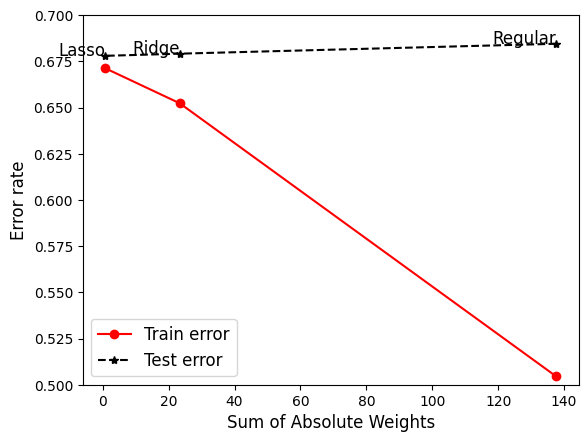

In [41]:
#### Training/Testing Error Rate Comparison over Sum of Absolute Weights       ####

columns = ['Model', 'Train error', 'Test error', 'Sum of Absolute Weights', 'Name']

values1 = [ "Regular", losses_regular[-1], test_losses_regular[-1], weight_sum_regular, 'Regular']

values2 = [ "Ridge(lamda=0.04)", losses_ridge[-1], test_losses_ridge[-1], weight_sum_ridge, 'Ridge']

values3 = [ "Lasso(lamda=0.01)", losses_lasso[-1], test_losses_lasso[-1], weight_sum_lasso, 'Lasso']


results = pandas.DataFrame([values1, values2, values3], columns=columns)

import matplotlib.pyplot as plt
plt.plot(results['Sum of Absolute Weights'], results['Train error'], 'ro-')
plt.plot(results['Sum of Absolute Weights'], results['Test error'], 'k*--')

# Annotate points with the 'Name' column
for i in range(len(results)):
    plt.text(results['Sum of Absolute Weights'][i], results['Test error'][i],
             results['Name'][i], fontsize=12, ha='right')

plt.legend(['Train error', 'Test error'], fontsize=12)
plt.ylim(0.5, 0.7)
plt.xlabel('Sum of Absolute Weights', fontsize=12)
plt.ylabel('Error rate', fontsize=12)
plt.savefig('./A2_partII_q1.png')

results

#### Plotting Template for Part II Question (3)

In [42]:
########## Lasso Fitting ########## ridge
lamda1 = 3.0
theta_lasso, losses_lasso, test_losses_lasso = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.05, epochs=2000, lambda_=lamda1, regularizer='ridge'
)
y_pred_train_lasso = predict(X_train, theta_lasso)
y_pred_test_lasso = predict(X_test, theta_lasso)
bias_lasso = theta_lasso[0]
weight_lasso = theta_lasso[1:]
weight_sum_lasso = numpy.absolute(weight_lasso).sum() + numpy.absolute(bias_lasso)

Epoch 0, Train Loss: 1.14043 Test Loss: 1.01358
Epoch 200, Train Loss: 0.68478 Test Loss: 0.68822
Epoch 400, Train Loss: 0.68475 Test Loss: 0.68835
Epoch 600, Train Loss: 0.68475 Test Loss: 0.68837
Epoch 800, Train Loss: 0.68475 Test Loss: 0.68838
Epoch 1000, Train Loss: 0.68475 Test Loss: 0.68838
Epoch 1200, Train Loss: 0.68475 Test Loss: 0.68838
Epoch 1400, Train Loss: 0.68475 Test Loss: 0.68838
Epoch 1600, Train Loss: 0.68475 Test Loss: 0.68838
Epoch 1800, Train Loss: 0.68475 Test Loss: 0.68838

Final Result:
Total Epoch 2000, Train Loss: 0.68475 Test Loss: 0.68838


In [43]:
########## Lasso Fitting ##########
lamda2 = 2.0
theta_lasso1, losses_lasso1, test_losses_lasso1 = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.05, epochs=2000, lambda_=lamda2, regularizer='ridge'
)
y_pred_train_lasso1 = predict(X_train, theta_lasso1)
y_pred_test_lasso1 = predict(X_test, theta_lasso1)
bias_lasso1 = theta_lasso1[0]
weight_lasso1 = theta_lasso1[1:]
weight_sum_lasso1 = numpy.absolute(weight_lasso1).sum() + numpy.absolute(bias_lasso1)

Epoch 0, Train Loss: 0.99718 Test Loss: 0.93872
Epoch 200, Train Loss: 0.68214 Test Loss: 0.68669
Epoch 400, Train Loss: 0.68209 Test Loss: 0.68686
Epoch 600, Train Loss: 0.68209 Test Loss: 0.68689
Epoch 800, Train Loss: 0.68209 Test Loss: 0.68690
Epoch 1000, Train Loss: 0.68209 Test Loss: 0.68690
Epoch 1200, Train Loss: 0.68209 Test Loss: 0.68690
Epoch 1400, Train Loss: 0.68209 Test Loss: 0.68690
Epoch 1600, Train Loss: 0.68209 Test Loss: 0.68690
Epoch 1800, Train Loss: 0.68209 Test Loss: 0.68690

Final Result:
Total Epoch 2000, Train Loss: 0.68209 Test Loss: 0.68690


In [44]:
########## Lasso Fitting ##########
lamda3 = 1.5
theta_lasso2, losses_lasso2, test_losses_lasso2 = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.05, epochs=2000, lambda_=lamda3, regularizer='ridge'
)
y_pred_train_lasso2 = predict(X_train, theta_lasso2)
y_pred_test_lasso2 = predict(X_test, theta_lasso2)
bias_lasso2 = theta_lasso2[0]
weight_lasso2 = theta_lasso2[1:]
weight_sum_lasso2 = numpy.absolute(weight_lasso2).sum() + numpy.absolute(bias_lasso2)

Epoch 0, Train Loss: 0.92828 Test Loss: 0.89278
Epoch 200, Train Loss: 0.68003 Test Loss: 0.68554
Epoch 400, Train Loss: 0.67994 Test Loss: 0.68573
Epoch 600, Train Loss: 0.67994 Test Loss: 0.68578
Epoch 800, Train Loss: 0.67994 Test Loss: 0.68579
Epoch 1000, Train Loss: 0.67994 Test Loss: 0.68579
Epoch 1200, Train Loss: 0.67994 Test Loss: 0.68579
Epoch 1400, Train Loss: 0.67994 Test Loss: 0.68579
Epoch 1600, Train Loss: 0.67994 Test Loss: 0.68579
Epoch 1800, Train Loss: 0.67994 Test Loss: 0.68579

Final Result:
Total Epoch 2000, Train Loss: 0.67994 Test Loss: 0.68579


In [45]:
########## Lasso Fitting ##########
lamda4 = 1.0
theta_lasso3, losses_lasso3, test_losses_lasso3 = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.05, epochs=2000, lambda_=lamda4, regularizer='ridge'
)
y_pred_train_lasso3 = predict(X_train, theta_lasso3)
y_pred_test_lasso3 = predict(X_test, theta_lasso3)
bias_lasso3 = theta_lasso3[0]
weight_lasso3 = theta_lasso3[1:]
weight_sum_lasso3 = numpy.absolute(weight_lasso3).sum() + numpy.absolute(bias_lasso3)

Epoch 0, Train Loss: 0.84228 Test Loss: 0.82527
Epoch 200, Train Loss: 0.67679 Test Loss: 0.68398
Epoch 400, Train Loss: 0.67662 Test Loss: 0.68418
Epoch 600, Train Loss: 0.67661 Test Loss: 0.68425
Epoch 800, Train Loss: 0.67661 Test Loss: 0.68426
Epoch 1000, Train Loss: 0.67661 Test Loss: 0.68427
Epoch 1200, Train Loss: 0.67661 Test Loss: 0.68427
Epoch 1400, Train Loss: 0.67661 Test Loss: 0.68427
Epoch 1600, Train Loss: 0.67661 Test Loss: 0.68427
Epoch 1800, Train Loss: 0.67661 Test Loss: 0.68427

Final Result:
Total Epoch 2000, Train Loss: 0.67661 Test Loss: 0.68427


,Model,Train error,Test error,Sum of Absolute Weights,Name
0,"[-0.12657492940313425, -0.00012540466826752524...",0.684752,0.688376,1.080500,$\lambda$ = 3.0
1,"[-0.16191961007651814, -0.00018580513531400811...",0.682087,0.686901,1.510878,$\lambda$ = 2.0
2,"[-0.18901445363111627, -0.0002452550791318926,...",0.679942,0.685788,1.908907,$\lambda$ = 1.5
3,"[-0.22818975386601936, -0.00036203692467454363...",0.676610,0.684268,2.644995,$\lambda$ = 1.0


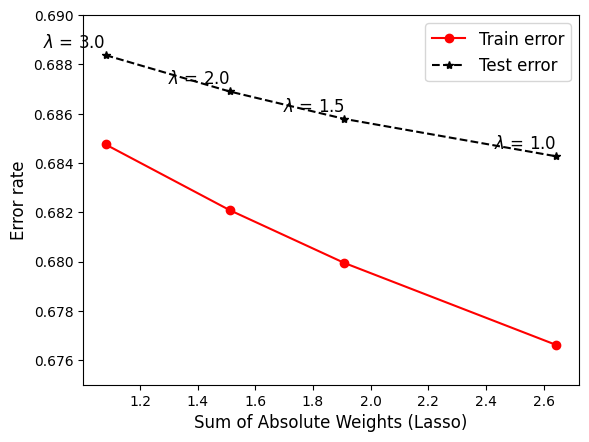

In [50]:
columns = ['Model', 'Train error', 'Test error', 'Sum of Absolute Weights', 'Name']

values = [ theta_lasso, losses_lasso[-1], test_losses_lasso[-1], weight_sum_lasso, r'$\lambda$ = ' + str(lamda1)]

values1 = [ theta_lasso1, losses_lasso1[-1], test_losses_lasso1[-1], weight_sum_lasso1, r'$\lambda$ = ' + str(lamda2)]

values2 = [ theta_lasso2, losses_lasso2[-1], test_losses_lasso2[-1], weight_sum_lasso2, r'$\lambda$ = ' + str(lamda3)]

values3 = [ theta_lasso3, losses_lasso3[-1], test_losses_lasso3[-1], weight_sum_lasso3, r'$\lambda$ = ' + str(lamda4)]


results = pandas.DataFrame([values, values1, values2, values3], columns=columns)

import matplotlib.pyplot as plt
plt.plot(results['Sum of Absolute Weights'], results['Train error'], 'ro-')
plt.plot(results['Sum of Absolute Weights'], results['Test error'], 'k*--')

# Annotate points with the 'Name' column
for i in range(len(results)):
    plt.text(results['Sum of Absolute Weights'][i]+0.001, results['Test error'][i]+0.0003,
             results['Name'][i], fontsize=12, ha='right')

plt.legend(['Train error', 'Test error'], fontsize=12)
plt.ylim(0.675, 0.69)
plt.xlabel('Sum of Absolute Weights (Lasso)', fontsize=12)
plt.ylabel('Error rate', fontsize=12)
plt.savefig('./A2_partII_q3.png')

results

#### Bonus

In [51]:
from sentence_transformers import SentenceTransformer
import pandas as pd

df = pd.read_csv("diplomacy_cv.csv")

model = SentenceTransformer('all-MiniLM-L6-v2')
X_text = model.encode(df['text'].tolist(), convert_to_numpy=True)

X_extra = df[['meta.relative_message_index', 'meta.year', 'meta.game_score_delta']].fillna(0).to_numpy()
X_advanced = np.hstack([X_text, X_extra])
y_advanced = df['intent'].to_numpy()

print("X shape:", X_advanced.shape)
print("y shape:", y_advanced.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

X shape: (1596, 387)
y shape: (1596,)


In [52]:
# Train/test split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_advanced = scaler.fit_transform(X_advanced)

split = int(0.8 * len(X_advanced))
X_train, X_test = X_advanced[:split], X_advanced[split:]
y_train, y_test = y_advanced[:split], y_advanced[split:]

X_train = add_intercept(np.array(X_train))
y_train = np.array(y_train).astype(np.float64)
X_test = add_intercept(np.array(X_test))
y_test = np.array(y_test).astype(np.float64)

In [89]:
########################################
########## Regular Fitting ##########
########################################
theta_regular, losses_regular, test_losses_regular = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.01, epochs=2000, lambda_=0, regularizer='none'
)
y_pred_train_regular = predict(X_train, theta_regular)
y_pred_test_regular = predict(X_test, theta_regular)

bias_regular = theta_regular[0]
weight_regular = theta_regular[1:]
weight_sum_regular = numpy.absolute(weight_regular).sum() + numpy.absolute(bias_regular)

Epoch 0, Train Loss: 0.69946 Test Loss: 0.69931
Epoch 200, Train Loss: 0.58175 Test Loss: 0.63145
Epoch 400, Train Loss: 0.54978 Test Loss: 0.62962
Epoch 600, Train Loss: 0.53121 Test Loss: 0.63466
Epoch 800, Train Loss: 0.51868 Test Loss: 0.64169
Epoch 1000, Train Loss: 0.50943 Test Loss: 0.64921
Epoch 1200, Train Loss: 0.50221 Test Loss: 0.65665
Epoch 1400, Train Loss: 0.49635 Test Loss: 0.66381
Epoch 1600, Train Loss: 0.49144 Test Loss: 0.67063
Epoch 1800, Train Loss: 0.48724 Test Loss: 0.67708

Final Result:
Total Epoch 2000, Train Loss: 0.48360 Test Loss: 0.67708


In [88]:
########################################
########## Ridge Fitting ############
########################################
theta_ridge, losses_ridge, test_losses_ridge = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.0005, epochs=6000, lambda_=0.0004, regularizer='ridge'
)
y_pred_train_ridge = predict(X_train, theta_ridge)
y_pred_test_ridge = predict(X_test, theta_ridge)
bias_ridge = theta_ridge[0]
weight_ridge = theta_ridge[1:]
weight_sum_ridge = numpy.absolute(weight_ridge).sum() + numpy.absolute(bias_ridge)

Epoch 0, Train Loss: 0.69678 Test Loss: 0.70092
Epoch 200, Train Loss: 0.67380 Test Loss: 0.68289
Epoch 400, Train Loss: 0.65826 Test Loss: 0.67171
Epoch 600, Train Loss: 0.64703 Test Loss: 0.66438
Epoch 800, Train Loss: 0.63842 Test Loss: 0.65926
Epoch 1000, Train Loss: 0.63147 Test Loss: 0.65548
Epoch 1200, Train Loss: 0.62561 Test Loss: 0.65253
Epoch 1400, Train Loss: 0.62052 Test Loss: 0.65013
Epoch 1600, Train Loss: 0.61598 Test Loss: 0.64812
Epoch 1800, Train Loss: 0.61186 Test Loss: 0.64639
Epoch 2000, Train Loss: 0.60808 Test Loss: 0.64489
Epoch 2200, Train Loss: 0.60456 Test Loss: 0.64355
Epoch 2400, Train Loss: 0.60128 Test Loss: 0.64237
Epoch 2600, Train Loss: 0.59819 Test Loss: 0.64131
Epoch 2800, Train Loss: 0.59528 Test Loss: 0.64036
Epoch 3000, Train Loss: 0.59251 Test Loss: 0.63951
Epoch 3200, Train Loss: 0.58989 Test Loss: 0.63875
Epoch 3400, Train Loss: 0.58738 Test Loss: 0.63807
Epoch 3600, Train Loss: 0.58500 Test Loss: 0.63746
Epoch 3800, Train Loss: 0.58271 Test L

In [81]:
########################################
########## Lasso Fitting ############
########################################
theta_lasso, losses_lasso, test_losses_lasso = train_logistic_regression(
    X_train, y_train, X_test, y_test, lr=0.0005, epochs=6000, lambda_=0.00001, regularizer='lasso'
)
y_pred_train_lasso = predict(X_train, theta_lasso)
y_pred_test_lasso = predict(X_test, theta_lasso)
bias_lasso = theta_lasso[0]
weight_lasso = theta_lasso[1:]
weight_sum_lasso = numpy.absolute(weight_lasso).sum() + numpy.absolute(bias_lasso)

Epoch 0, Train Loss: 0.69893 Test Loss: 0.69983
Epoch 200, Train Loss: 0.67343 Test Loss: 0.67848
Epoch 400, Train Loss: 0.65715 Test Loss: 0.66600
Epoch 600, Train Loss: 0.64575 Test Loss: 0.65808
Epoch 800, Train Loss: 0.63716 Test Loss: 0.65268
Epoch 1000, Train Loss: 0.63029 Test Loss: 0.64877
Epoch 1200, Train Loss: 0.62454 Test Loss: 0.64578
Epoch 1400, Train Loss: 0.61956 Test Loss: 0.64340
Epoch 1600, Train Loss: 0.61513 Test Loss: 0.64144
Epoch 1800, Train Loss: 0.61112 Test Loss: 0.63978
Epoch 2000, Train Loss: 0.60743 Test Loss: 0.63835
Epoch 2200, Train Loss: 0.60400 Test Loss: 0.63711
Epoch 2400, Train Loss: 0.60079 Test Loss: 0.63601
Epoch 2600, Train Loss: 0.59777 Test Loss: 0.63505
Epoch 2800, Train Loss: 0.59491 Test Loss: 0.63420
Epoch 3000, Train Loss: 0.59220 Test Loss: 0.63345
Epoch 3200, Train Loss: 0.58962 Test Loss: 0.63279
Epoch 3400, Train Loss: 0.58715 Test Loss: 0.63221
Epoch 3600, Train Loss: 0.58480 Test Loss: 0.63170
Epoch 3800, Train Loss: 0.58254 Test L

,Model,Train error,Test error,Sum of Absolute Weights,Name
0,Regular,0.483602,0.677082,23.904004,Regular
1,Ridge(lamda=4e-4),0.562659,0.634230,8.745509,Ridge
2,Lasso(lamda=1e-5),0.562630,0.629441,8.600670,Lasso


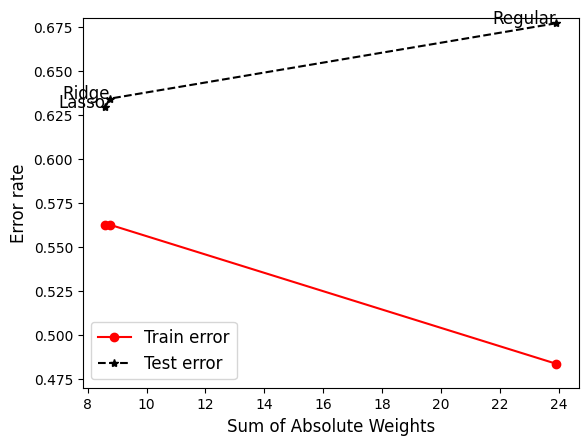

In [92]:
#### Training/Testing Error Rate Comparison over Sum of Absolute Weights       ####

columns = ['Model', 'Train error', 'Test error', 'Sum of Absolute Weights', 'Name']

values1 = [ "Regular", losses_regular[-1], test_losses_regular[-1], weight_sum_regular, 'Regular']

values2 = [ "Ridge(lamda=4e-4)", losses_ridge[-1], test_losses_ridge[-1], weight_sum_ridge, 'Ridge']

values3 = [ "Lasso(lamda=1e-5)", losses_lasso[-1], test_losses_lasso[-1], weight_sum_lasso, 'Lasso']


results = pandas.DataFrame([values1, values2, values3], columns=columns)

import matplotlib.pyplot as plt
plt.plot(results['Sum of Absolute Weights'], results['Train error'], 'ro-')
plt.plot(results['Sum of Absolute Weights'], results['Test error'], 'k*--')

# Annotate points with the 'Name' column
for i in range(len(results)):
    plt.text(results['Sum of Absolute Weights'][i], results['Test error'][i],
             results['Name'][i], fontsize=12, ha='right')

plt.legend(['Train error', 'Test error'], fontsize=12)
plt.ylim(0.47, 0.68)
plt.xlabel('Sum of Absolute Weights', fontsize=12)
plt.ylabel('Error rate', fontsize=12)
plt.savefig('./A2_partII_q5.png')

results

#### SKlearn 比較(不用執行)

In [ ]:
# 訓練 ridge logistic regression
model = LogisticRegression(penalty='l1', C=1/0.1, solver='liblinear', fit_intercept=False)
#model = Ridge(alpha=0.4)
model.fit(X_train, y_train)

# 預測與評估
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_error = numpy.sqrt(mean_squared_error(y_train, y_pred_train))
test_error = numpy.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train Error: {train_error:.4f}, Test Error: {test_error:.4f}")

Train Error: 0.4409, Test Error: 0.6374


In [ ]:
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Lasso
from sklearn.metrics import accuracy_score

sk_model = LogisticRegression(penalty='l2', C= 1/0.1, solver='liblinear', fit_intercept=False)  # C=1/λ
#sk_model = Ridge(alpha=0.4)
#sk_model = Lasso(alpha=0.02)
sk_model.fit(X_train_b, y_train_b)

y_pred_train_sk = sk_model.predict(X_train_b)
y_pred_test_sk = sk_model.predict(X_test_b)

y_pred_train_class = (y_pred_train_sk >= 0.5).astype(int)
y_pred_test_class = (y_pred_test_sk >= 0.5).astype(int)

sk_train_error = numpy.sqrt(mean_squared_error(y_train_b, y_pred_train_class))
sk_test_error = numpy.sqrt(mean_squared_error(y_test_b, y_pred_test_class))

sk_weight_sum = np.abs(sk_model.coef_).sum() + np.abs(sk_model.intercept_)

print("=== Sklearn ===")
print(f"Train Error: {sk_train_error:.4f}, Test Error: {sk_test_error:.4f}")
sk_weight_sum = float(np.abs(sk_model.coef_).sum() + np.abs(sk_model.intercept_).sum())
print(f"Sum |Weights|: {sk_weight_sum:.4f}")

=== Sklearn ===
Train Error: 0.1455, Test Error: 0.6937
Sum |Weights|: 1608.0903
